<a href="https://colab.research.google.com/github/daffarayhanriadi/Capstone-ML/blob/main/Capstone_Model_1_NASNetMobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import os
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! chmod 600 /content/gdrive/MyDrive/Capstone/Dataset/kaggle.json

In [ ]:
# Link Dataset : https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification?datasetId=81794&sortBy=voteCount
# Mendownload Dataset
! KAGGLE_CONFIG_DIR=/content/gdrive/MyDrive/Capstone/Dataset/ kaggle datasets download -d asdasdasasdas/garbage-classification

 96% 79.0M/82.0M [00:00<00:00, 121MB/s]
100% 82.0M/82.0M [00:00<00:00, 126MB/s]


In [ ]:
import zipfile

zipFile = '/content/garbage-classification.zip'

zip_file = zipfile.ZipFile(zipFile, 'r')
zip_file.extractall('/tmp/garbage-classification')
zip_file.close()

In [ ]:
base_dir = '/tmp/garbage-classification/Garbage classification/Garbage classification'

In [ ]:
classes = os.listdir(base_dir)
classes.remove('trash')
print(classes)

['glass', 'paper', 'cardboard', 'plastic', 'metal']


In [ ]:
filepaths=[]
labels=[]
for klass in classes:
    classpath = os.path.join(base_dir, klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /tmp/garbage-classification/Garbage classifica...  glass
1  /tmp/garbage-classification/Garbage classifica...  glass
2  /tmp/garbage-classification/Garbage classifica...  glass
3  /tmp/garbage-classification/Garbage classifica...  glass
4  /tmp/garbage-classification/Garbage classifica...  glass
paper        594
glass        501
plastic      482
metal        410
cardboard    403
Name: labels, dtype: int64


In [ ]:
train_split = .8
test_split = .1
dummy_split = test_split/(1-train_split)

train_df, dummy_df = train_test_split(df, 
                                      train_size=train_split, 
                                      shuffle=True, 
                                      random_state=123)
test_df, valid_df = train_test_split(dummy_df, 
                                     train_size=dummy_split, 
                                     shuffle=True, 
                                     random_state=123)

print ('train_df length:', len(train_df), 
       '\ntest_df length:', len(test_df), 
       '\nvalid_df length:', len(valid_df))

train_df length: 1912 
test_df length: 239 
valid_df length: 239


In [ ]:
height = 256
width = 256
batch_size = 64

img_size = (height, width)
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]  
test_steps = int(length/test_batch_size)
print ('test batch size: ' , test_batch_size, '  test steps: ', test_steps)

gen = ImageDataGenerator(rescale=1./255,)
train_gen = gen.flow_from_dataframe(train_df, 
                                    x_col='filepaths', 
                                    y_col='labels', 
                                    target_size=img_size, 
                                    class_mode='categorical',
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    batch_size=batch_size)

validgen = ImageDataGenerator(rescale=1./255,)
valid_gen = validgen.flow_from_dataframe(valid_df, 
                                         x_col='filepaths', 
                                         y_col='labels', 
                                         target_size=img_size, 
                                         class_mode='categorical',
                                         color_mode='rgb', 
                                         shuffle=True, 
                                         batch_size=batch_size)

testgen = ImageDataGenerator(rescale=1./255,)
test_gen = testgen.flow_from_dataframe(test_df, 
                                       x_col='filepaths', 
                                       y_col='labels', 
                                       target_size=img_size, 
                                       class_mode='categorical',
                                       color_mode='rgb', 
                                       shuffle=False, 
                                       batch_size=test_batch_size)

test batch size:  1   test steps:  239
Found 1912 validated image filenames belonging to 5 classes.
Found 239 validated image filenames belonging to 5 classes.
Found 239 validated image filenames belonging to 5 classes.


In [ ]:
def show_image_samples(gen):
  test_dict=test_gen.class_indices
  classes=list(test_dict.keys())    
  images, labels = next(gen) # get a sample batch from the generator 
  plt.figure(figsize = (20, 20))
  length = len(labels)

  if length < 25: #show maximum of 25 images
    r = length
  else:
    r = 25

  for i in range(r):
      plt.subplot(5, 5, i + 1)
      image=images[i]
      plt.imshow(image)
      index=np.argmax(labels[i])
      class_name=classes[index]
      plt.title(class_name, color='blue', fontsize=16)
      plt.axis('off')
      
  plt.show()

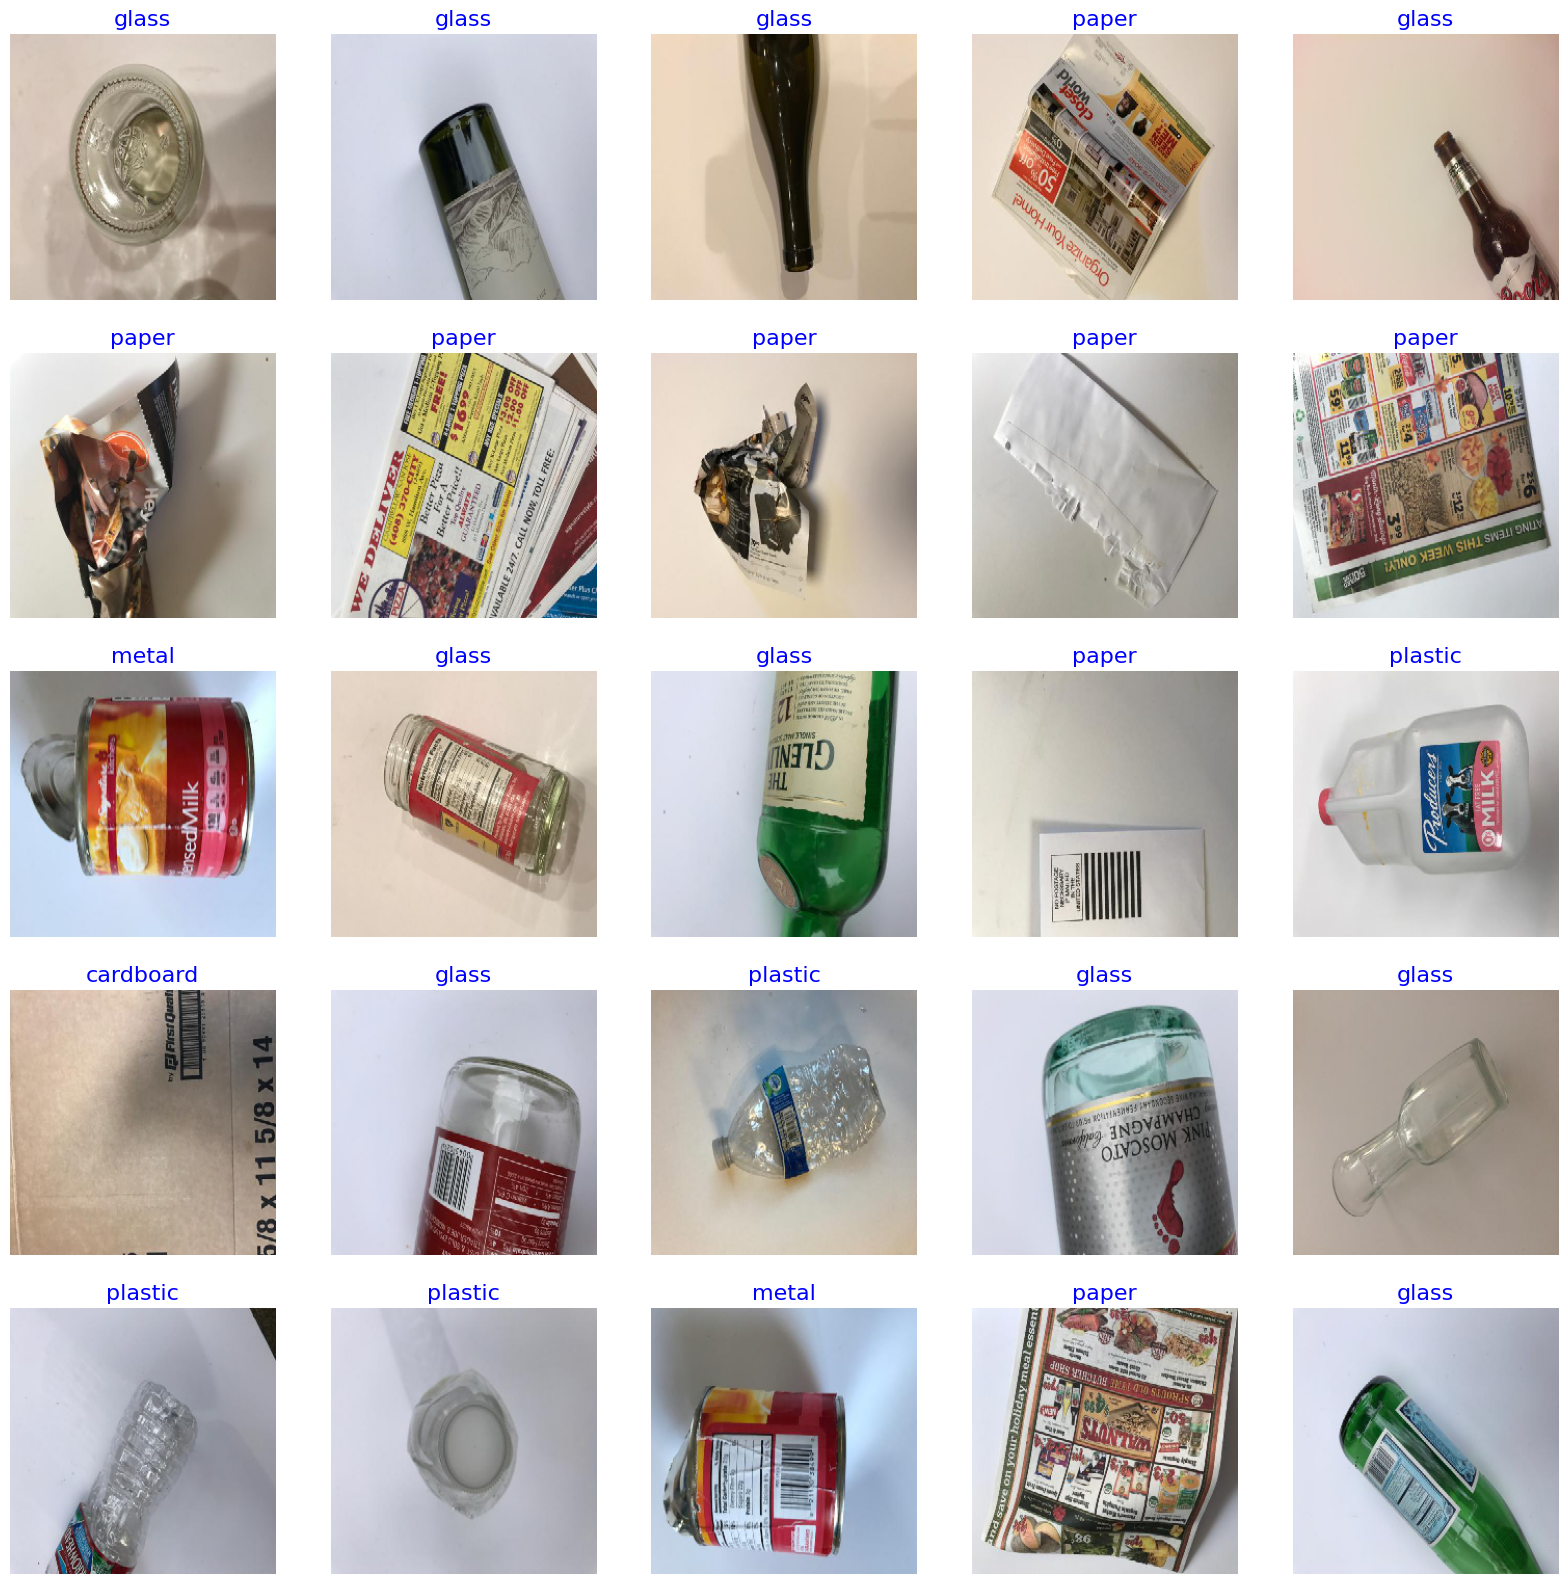

In [ ]:
show_image_samples(train_gen)

In [ ]:
base_model = tf.keras.applications.NASNetMobile(include_top=False, 
                                                weights="imagenet", 
                                                input_tensor=Input(shape=(128,128,3)))
base_model.summary()

19993432/19993432 [==============================] - 0s 0us/step
Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 63, 63, 32)   128         ['stem_conv1[0][0]']             
                                                                                                  
 activation (Activation)    

In [ ]:
base_model.trainable = False

In [ ]:
model_name = 'PelitaApp'
channels = 3
img_shape = (height, width, channels)
print("Building model with", base_model)

model = Sequential()
model.add(Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate=.001)
loss = categorical_crossentropy
model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])

model.build((None, *img_shape))

Building model with <keras.engine.functional.Functional object at 0x7f965afef640>


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 


In [ ]:
# grader-required-cell

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
epochs = 100
callbacks = myCallback()

history = model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callbacks)

In [ ]:
def print_in_color(txt_msg, fore_tupple, back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple

    msg = '\33[38;2;{};{};{};48;2;{};{};{}m{}'.format(rf, gf, bf, rb, gb, bb, txt_msg)

    print(msg, flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    
    for i in range (start_epoch, Epoch_count):
      Epochs.append(i + 1)   
      
    index_loss = np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch = ' + str(index_loss + 1 + start_epoch)
    vc_label='best epoch = ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

    axes[0].plot(Epochs, tloss, 'r', label = 'Training loss')
    axes[0].plot(Epochs, vloss,'g',label = 'Validation loss' )
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s = 150, c = 'blue', label = sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot (Epochs,tacc, 'r', label = 'Training Accuracy')
    axes[1].plot (Epochs, vacc,'g',label = 'Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s = 150, c = 'blue', label = vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames 
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []

    for key,value in class_dict.items():
        new_dict[value] = key # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) + '.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors = 0

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)        
        true_index = labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors = errors + 1
        y_pred.append(pred_index)

    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))

    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)

    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='pest'
acc = model.evaluate(test_gen, 
                     batch_size=test_batch_size, 
                     verbose=1, 
                     steps=test_steps, 
                     return_dict=False)[1] * 100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0),(55, 65, 80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [ ]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

In [ ]:
# untuk mengetahui urutan nomor class
print(train_gen.class_indices)

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()
 
for fn in uploaded.keys():
  # predicting images
  path = fn
  img = Image.open(path).convert('RGB')
  img = img.resize(img_size)
  
  x = np.array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
 
  classes = model.predict(images, batch_size=10)
  idx = np.argmax(classes)

  class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
  print(f"gambar ini menunjukkan {class_labels[idx]}")

  imgplot = plt.imshow(img)